**Emotion Detection by Roberta**

This project aims to detect emotions based on Tweets in 6 classes of0 "sadness", "joy","love","anger","fear","surprise". Accordingly, Roberta large language model which is a pretrained language model is fine-tuned based on the Twitter dataset.

RoBERTa, short for "Robustly optimized BERT approach," is a variation of BERT (Bidirectional Encoder Representations from Transformers), a popular model for natural language understanding developed by researchers at Facebook AI. RoBERTa is built upon the same architecture as BERT but incorporates several key improvements and changes in training methodology, resulting in better performance on various NLP tasks.



In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import EvalPrediction
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
from datasets import Dataset, DatasetDict
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

**Importing the dataset**

In [ ]:
data = pd.read_csv("text.csv")

Mapping the dataset to its equal class

In [ ]:
mapping = {0 : "sadness",
           1 : "joy",
           2 : "love",
           3 : "anger",
           4 : "fear",
           5 : "surprise"
}

data["emotion"] =  data["label"].map(mapping)

In [ ]:
data.head()

,Unnamed: 0,text,label,emotion
0,0,i just feel really helpless and heavy hearted,4.0,fear
1,1,ive enjoyed being able to slouch about relax a...,0.0,sadness
2,2,i gave up my internship with the dmrg and am f...,4.0,fear
3,3,i dont know i feel so lost,0.0,sadness
4,4,i am a kindergarten teacher and i am thoroughl...,4.0,fear


Train-Test and evaluation set:

Evaluation: 15%

Train : 68%

Test : 17

In [ ]:

np.random.seed(42)
data = data.sample(frac=1).reset_index(drop=True)

eval_ratio = 0.15
total = data.shape[0]
eval_end = int(total * eval_ratio)

eval_data = data[:eval_end]

data = data[eval_end:]
print(total, len(eval_data), len(data), len(eval_data) + len(data))

338471 50770 287701 338471




**Setting up the model**


In [ ]:
model_nm = "FacebookAI/roberta-base"

In [ ]:
#! pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 11.6 MB/s eta 0:00:00


In [ ]:
ds = Dataset.from_pandas(data)

Tokenizer

AutoTokenizer is a class from the Hugging Face Transformers library that provides functionality for automatically selecting and loading the appropriate tokenizer for a given pre-trained model.
This tokenizer can then be used to preprocess text data and convert it into numerical inputs that the RoBERTa model can understand during training or inference.

In [ ]:
tokz = AutoTokenizer.from_pretrained(model_nm)

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def tok_func(x): return tokz(x["text"])

In [ ]:
tokz_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/287701 [00:00<?, ? examples/s]

In [ ]:
#eval_tokz_ds = ds.map(tok_func, batched=True)

In [ ]:
eval_ds = Dataset.from_pandas(eval_data).map(tok_func, batched=True)

Map:   0%|          | 0/50770 [00:00<?, ? examples/s]

Train-Test split


In [ ]:
dds = tokz_ds.train_test_split(test_size=0.2)
dds

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'emotion', 'input_ids', 'attention_mask'],
        num_rows: 230160
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'emotion', 'input_ids', 'attention_mask'],
        num_rows: 57541
    })
})

**Args**

In [ ]:
bs = 96
lr = 8e-5
epochs = 1

In [ ]:
#!pip install transformers==4.17

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 24.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.1
    Uninstalling transformers-4.40.1:
      Successfully uninstalled transformers-4.40.1


The args variable to configure the training process for the model.

fp16=True enables mixed-precision training, which uses 16-bit floating-point format for some computations to speed up training and reduce memory usage.

In [ ]:
args = TrainingArguments(
    "outputs",
    learning_rate=lr,
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs,
    warmup_ratio=0.1,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    fp16=True,
    evaluation_strategy="epoch",
    report_to="none",
    save_total_limit=3
)

Metrics

In [ ]:


def multi_label_metrics(predictions, labels):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.argmax(probs, axis=1)
    y_true = labels
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }
    return metrics


def compute_metrics(p:EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(predictions= preds, labels = p[1])
    print(result)
    return result

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=6)
trainer = Trainer(
    model,
    args,
    train_dataset=dds["train"],
    eval_dataset=dds["test"],
    tokenizer=tokz,
    compute_metrics=compute_metrics
)

loading configuration file https://huggingface.co/FacebookAI/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a1462ede3948796d4f0b92fc0538bec1d072c3e9185be0d18eaa90b079ef5a1e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "FacebookAI/roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "ro

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: emotion, text, Unnamed: 0. If emotion, text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 230160
  Num Epochs = 1
  Instantaneous batch size per device = 96
  Total train batch size (w. parallel, distributed & accumulation) = 96
  Gradient Accumulation steps = 1
  Total optimization steps = 2398


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.095200,0.089597,0.940929,0.952939,0.864359,0.897034


Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.json
Deleting older checkpoint [outputs/checkpoint-1000] due to args.save_total_limit
Saving model checkpoint to outputs/checkpoint-1000
Configuration saved in outputs/checkpoint-1000/config.json
Model weights saved in outputs/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-1000/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-1000/special_tokens_map.json
Deleting older checkpoint [outputs/checkpoint-1500] due to args.save_total_limit
Saving model checkpoint to outputs/checkpoint-1500
Configuration saved in outputs/checkpoint-1500/config.json
Model weights saved in outputs/checkpoint-1500/pytorch_model.bin
tokenizer 

{'accuracy': 0.9409290766583828, 'precision': 0.9529391463641792, 'recall': 0.8643594390951002, 'f1_score': 0.8970343880700646}




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2398, training_loss=0.18144579864323784, metrics={'train_runtime': 830.6014, 'train_samples_per_second': 277.1, 'train_steps_per_second': 2.887, 'total_flos': 6935478271645824.0, 'train_loss': 0.18144579864323784, 'epoch': 1.0})

In [ ]:
trainer.save_model("BERT_Emotions")


Saving model checkpoint to BERT_Emotions
Configuration saved in BERT_Emotions/config.json
Model weights saved in BERT_Emotions/pytorch_model.bin
tokenizer config file saved in BERT_Emotions/tokenizer_config.json
Special tokens file saved in BERT_Emotions/special_tokens_map.json


In [ ]:
preds = trainer.predict(eval_ds).predictions.astype(float)
print(multi_label_metrics(preds, eval_ds['label']))

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: emotion, text, Unnamed: 0. If emotion, text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 50770
  Batch size = 192


{'accuracy': 0.9421311798306087, 'precision': 0.9537525051697843, 'recall': 0.8695578800153602, 'f1_score': 0.9010425104983425}
{'accuracy': 0.9421311798306087, 'precision': 0.9537525051697843, 'recall': 0.8695578800153602, 'f1_score': 0.9010425104983425}


In [ ]:
output_file_path = "predictions.txt"
with open(output_file_path, "w") as file:
    for pred in preds:
        file.write(str(pred) + "\n")

In [ ]:
from google.colab import files
files.download('/content/predictions.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: emotion, text, Unnamed: 0. If emotion, text, Unnamed: 0 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 50770
  Batch size = 192


{'accuracy': 0.9421311798306087, 'precision': 0.9537525051697843, 'recall': 0.8695578800153602, 'f1_score': 0.9010425104983425}


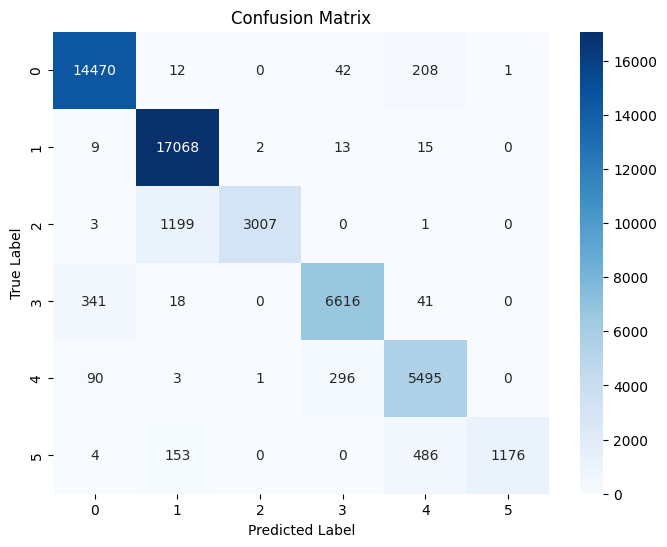

In [ ]:
# prompt: confusion matrix with plot


# Get the predictions and true labels
preds = trainer.predict(eval_ds).predictions.astype(float)
true_labels = eval_ds['label']

# Create a confusion matrix
cm = pd.crosstab(true_labels, np.argmax(preds, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


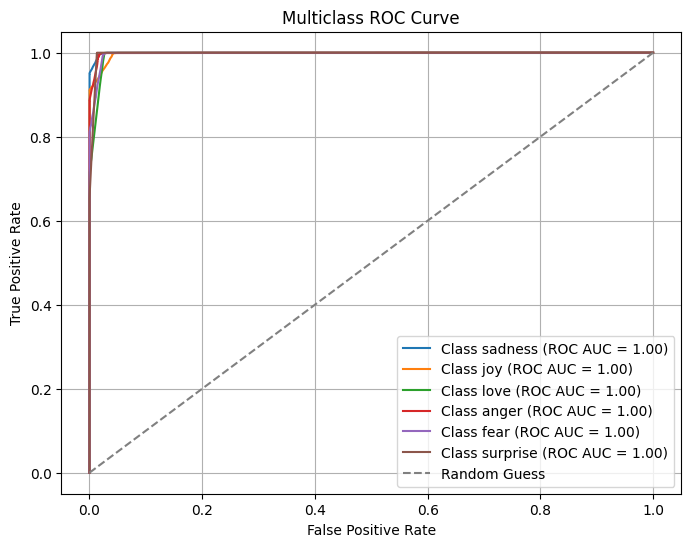

In [ ]:

roc_auc_scores = []
fpr_all = []
tpr_all = []
true_labels_arr = np.array(true_labels)
for i in range(6):  # Loop over each class
    # Calculate ROC AUC score for the i-th class
    roc_auc = roc_auc_score(true_labels_arr == i, preds[:, i])
    roc_auc_scores.append(roc_auc)

    # Compute ROC curve for the i-th class
    fpr, tpr, _ = roc_curve(true_labels_arr == i, preds[:, i])
    fpr_all.append(fpr)
    tpr_all.append(tpr)

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(6):
    plt.plot(fpr_all[i], tpr_all[i], label='Class {} (ROC AUC = {:.2f})'.format(mapping[i], roc_auc_scores[i]))

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend()
plt.grid(True)
plt.show()